In [1]:
import os, sys
import math

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch

In [2]:
sys.path.append('..')

In [3]:
from src.capture import LazyCapture
from src.cleaning import select_channel, remove_outside_petri
from src.labels import load_labels

In [ ]:
# TODO: random reader
def load(cls, path): # 'path' can be either a '.avi' or a wildcard for '.jpeg' images
        length, W, H, C = None, None, None, None
        cap = cv2.VideoCapture(path)
        ret, _ = cap.read()
        if not ret:
            cap.release()
            raise Exception("Couldn't read video file: " + path)
        else:
            length, W, H, C = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), 3
        cap.release()

        def frames(reverse=False):
            cap = cv2.VideoCapture(path)
            frame_no = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_no)
            ret, frame = cap.read()
            while ret and frame_no >= 0:
                yield frame_no, frame
                frame_no = frame_no - 1
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_no)
                ret, frame = cap.read()
            cap.release()
        return cls(length, W, H, C, frames)

In [3]:
cap = LazyCapture.load('../data/pw1_A1_0315_part2.avi')
labels = load_labels('../data/pw1_A1_0315_part2.txt')

In [4]:
cap.apply(remove_outside_petri((cap.W() // 2, cap.H() //2), int(cap.W()*0.9) // 2, (int(cap.H()*0.9) // 2)))
cap.apply(lambda i, f: (select_channel(0)(i, f) / 255.0).astype(np.float32), shape=(cap.W(), cap.H(), 1))

labels = {k: (v[0] / float(cap.W()), v[1] / float(cap.H()))  for k, v in labels.items()}

In [5]:
print("Info: ", cap.length(), cap.W(), cap.H(), cap.C())
print("Labels: ", len(labels))

Info:  16010 648 686 1
Labels:  15161


In [6]:
import itertools as it
class FramesDataset(torch.utils.data.IterableDataset):
    def __init__(self, capture, labels):
        self.capture = capture
        self.labels = dict(list(labels.items())[1:])

    def __iter__(self):
        def frames():
            for i, frame in self.capture.frames():
                if i in self.labels:
                    frame = torch.from_numpy(np.transpose(frame, axes=(2, 0, 1)))
                    label = torch.Tensor(self.labels[i])
                    yield frame, label
        return iter(frames())

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

INIT_LR = 1e-3
BATCH_SIZE = 1
EPOCHS = 1

In [8]:
loader = torch.utils.data.DataLoader(FramesDataset(cap, labels), batch_size=BATCH_SIZE)

In [9]:
class Custom_model(torch.nn.Module):
    # Models in PyTorch usually inherit from this Module
    def __init__(self, numChannels):
        super(Custom_model, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=numChannels, out_channels=3, kernel_size=(7, 6))
        self.relu1 = torch.nn.ReLU()
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=(3, 3))

        self.conv2 = torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(7, 6))
        self.relu2 = torch.nn.ReLU()
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=(3, 3))

        self.conv3 = torch.nn.Conv2d(in_channels=6, out_channels=12, kernel_size=(7, 6))
        self.relu3 = torch.nn.ReLU()
        self.maxpool3 = torch.nn.MaxPool2d(kernel_size=(3, 3))

        self.conv4 = torch.nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(7, 6))
        self.relu4 = torch.nn.ReLU()
        self.maxpool4 = torch.nn.MaxPool2d(kernel_size=(3, 3))

        self.fc1 = torch.nn.Linear(300, 600)
        self.fc2 = torch.nn.Linear(600, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.maxpool4(x)
        x = self.fc1(x.flatten())
        x = self.fc2(x)
        return x

In [10]:
model = Custom_model(numChannels=1).cuda()

In [11]:
opt = torch.optim.Adam(model.parameters(), lr=INIT_LR)
crit = torch.nn.MSELoss()

In [12]:
full_loss_history = []
loss_history = []
for epoch in range(1, EPOCHS + 1):
    model.train() 

    loss_history = []
    batch_idx = 1
    for data, label in loader:
        data, label = data.to(device), label.to(device)

        pred = model(data)
        loss = crit(pred, label)

        opt.zero_grad()
        loss.backward()
        opt.step()

        loss_history.append(loss.item())

        if batch_idx % 100 == 0:
            print(
                f"Train Epoch: {epoch}-{batch_idx} batch_loss={loss.item():0.2e}"
            )
        batch_idx = batch_idx + 1

    full_loss_history.extend(loss_history)

/home/gbm/miniconda3/envs/ML-DL/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train Epoch: 1-100 batch_loss=1.35e-05
Train Epoch: 1-200 batch_loss=3.38e-05
Train Epoch: 1-300 batch_loss=1.29e-05
Train Epoch: 1-400 batch_loss=6.88e-06
Train Epoch: 1-500 batch_loss=6.89e-06
Train Epoch: 1-600 batch_loss=4.76e-07
Train Epoch: 1-700 batch_loss=4.00e-06
Train Epoch: 1-800 batch_loss=3.95e-06
Train Epoch: 1-900 batch_loss=3.46e-05
Train Epoch: 1-1000 batch_loss=6.93e-06
Train Epoch: 1-1100 batch_loss=8.41e-05
Train Epoch: 1-1200 batch_loss=1.20e-06
Train Epoch: 1-1300 batch_loss=3.38e-06
Train Epoch: 1-1400 batch_loss=7.02e-07
Train Epoch: 1-1500 batch_loss=1.13e-06
Train Epoch: 1-1600 batch_loss=3.27e-09
Train Epoch: 1-1700 batch_loss=1.15e-06
Train Epoch: 1-1800 batch_loss=1.57e-06
Train Epoch: 1-1900 batch_loss=1.03e-05
Train Epoch: 1-2000 batch_loss=1.19e-06
Train Epoch: 1-2100 batch_loss=2.80e-06
Train Epoch: 1-2200 batch_loss=4.21e-06
Train Epoch: 1-2300 batch_loss=5.36e-06
Train Epoch: 1-2400 batch_loss=8.26e-06
Train Epoch: 1-2500 batch_loss=3.76e-05
Train Epo

Text(0, 0.5, 'Loss')

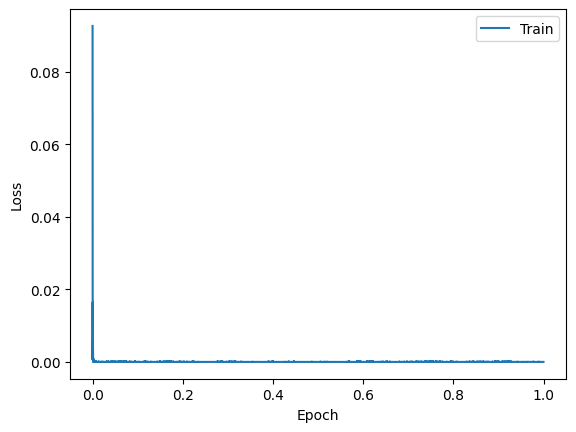

In [13]:
# ===== Plot training curves =====
n_train = len(full_loss_history)
t_train = EPOCHS * np.arange(n_train) / n_train
t_val = np.arange(1, EPOCHS + 1)
plt.figure()
plt.plot(t_train, full_loss_history, label="Train")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Eval

In [21]:
from src.debug import print_frame

In [22]:
cap_e = LazyCapture.load('../data/pw1_A1_0315_part1.avi')
labels_e = load_labels('../data/pw1_A1_0315_part1.txt')

cap_e.apply(remove_outside_petri((cap.W() // 2, cap.H() //2), int(cap.W()*0.9) // 2, (int(cap.H()*0.9) // 2)))
cap_e.apply(lambda i, f: (select_channel(0)(i, f) / 255.0).astype(np.float32), shape=(cap.W(), cap.H(), 1))

labels_e = {k: (v[0] / float(cap.W()), v[1] / float(cap.H()))  for k, v in labels_e.items()}

In [23]:
loader_e = torch.utils.data.DataLoader(FramesDataset(cap_e, labels_e), batch_size=1)

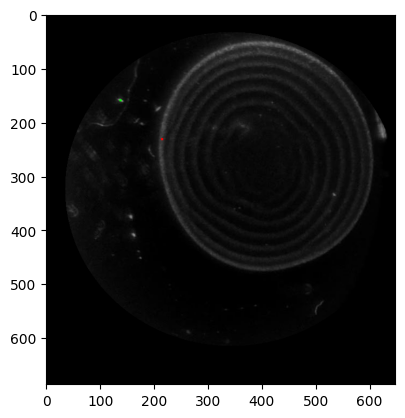

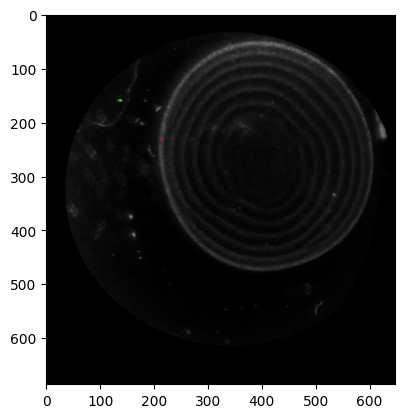

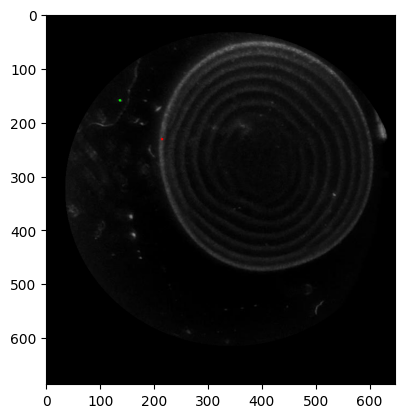

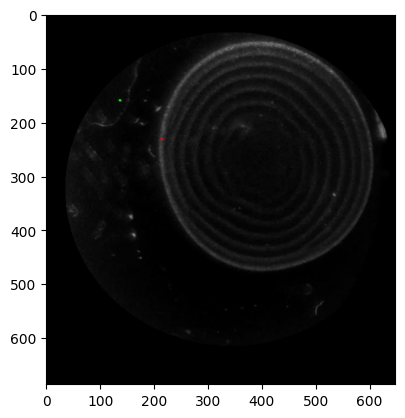

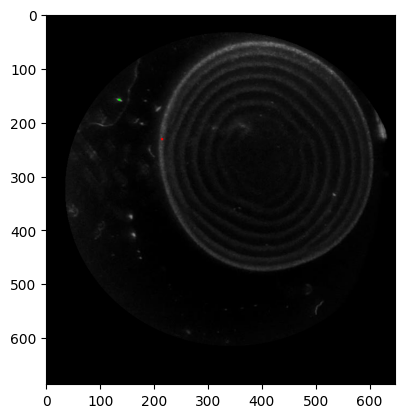

In [24]:
with torch.no_grad():
    for data, label in it.islice(loader_e, 2000, 2050, 10):
        data, label = data.to(device), label.to(device)
        pred = model(data)

        frame = np.transpose((data[0].cpu().numpy() * 255.0).astype(np.uint8), axes=(1, 2, 0))
        true_pos = (label[0].cpu().numpy() * np.array([cap.W(), cap.H()])).astype(np.int32)
        pred_pos = (pred.cpu().numpy() * np.array([cap.W(), cap.H()])).astype(np.int32)
        print_frame(True)(0, frame, (true_pos, pred_pos))
        